# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
import numpy as np
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

### Consolidar Base de Dados

In [2]:
#Importando as bases de dados

#criando variavel para guardar o caminho das bases de dados
caminho_bases = pathlib.Path(r'D:\Documentos\Hashtag Treinamentos\1 - Python\17. Projeto de ciencia de dados - aplicação ao mercado de trabalho\Projeto AirBnb Rj\Dados')

#criando um dicionario com o nome do mes e o numeral do mes
meses = {'jan':1, 'fev':2, 'mar':3, 'abr':4, 'mai':5, 'jun':6, 'jul':7, 'ago':8, 'set':9, 'out':10, 'nov':11, 'dez':12}

#criando uma lista vazia para alimentar com as bases de dados
bases = []

#percorrendo a pasta e alimentando a lista
for arquivo in caminho_bases.iterdir():
      df = pd.read_csv(caminho_bases / arquivo.name)
      df['Ano'] = int(arquivo.name[-8:-4])
      df['Mês'] = meses[arquivo.name[:3]]
      bases.append(df)

#transformando a lista em um df
base_airbnb = pd.concat(bases)


display(base_airbnb.head(3))

C:\Users\Igor\AppData\Local\Temp\ipykernel_8788\2834060638.py:14: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\Igor\AppData\Local\Temp\ipykernel_8788\2834060638.py:14: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\Igor\AppData\Local\Temp\ipykernel_8788\2834060638.py:14: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\Igor\AppData\Local\Temp\ipykernel_8788\2834060638.py:14: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\Igor\AppData\Local\Temp\ipykernel_8788\2834060638.py:14: DtypeWarning: Columns (61,62,94) have mixed types. Spec

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
Além disso uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso vamos excluir algumas colunas da nossa base.
- Tipos de colunas que vamos excluir:
- IDs, links e informações nao relevantes para o modelo
- Colunas repetidas ou parecidas que dao a mesma informação
- Colunas preenchidas com texto livre, nao rodaremos nenhuma analise por palavra
- Colunas em que todos ou quase todos os valores sao iguais

In [3]:
#gerando um excel para uma analise das colunas
base_airbnb.head(1000).to_csv(r'D:\Documentos\Hashtag Treinamentos\1 - Python\17. Projeto de ciencia de dados - aplicação ao mercado de trabalho\Projeto AirBnb Rj\bkp_files\Analise_colunas.csv', index=False, sep=';')

### Analisando as colunas

In [4]:
#verificando se tem valores preenchidos na coluna
print(base_airbnb[['experiences_offered']].value_counts())

# nenhum valor preenchido

experiences_offered
none                   902210
Name: count, dtype: int64


In [5]:
#verificando se as colunas sao repetidas
print((base_airbnb['host_listings_count']==base_airbnb['host_total_listings_count']).value_counts())

# muitos valores repetidos

True     901750
False       460
Name: count, dtype: int64


In [6]:
#verificando quantos valores sao nulls
print(base_airbnb['square_feet'].isnull().sum())

# muitos valores nulls

888162


In [7]:
#filtrando as colunas desejadas
base_airbnb = base_airbnb[['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','Ano','Mês'
]]

### Tratar Valores Faltando

In [8]:
#Identificando quais colunas tem valores 'nan'

#As colunas com dados > 300_000 faltantes foram excluidas
for coluna in base_airbnb:
      if base_airbnb[coluna].isnull().sum() > 300_000:
            base_airbnb = base_airbnb.drop(coluna, axis=1)

#As demais colunas, como temos muitas linhas (900_000) vamos excluir as linhas que contem dados NaN
base_airbnb = base_airbnb.dropna()

print(base_airbnb.isnull().sum())

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
Ano                         0
Mês                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [9]:
print(base_airbnb.dtypes)
print('-'*80)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
Ano                           int64
Mês                           int64
dtype: object
--------------------------------------------------------------------------------
host_is_superhost                                                           f

Como o Preço e extrapeople estao sendo reconhecidos como objeto ao inves de float, temos que mudar o tipo da coluna.

In [10]:
#Mudar tipo de dados da coluna price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)

#mudar tipo de dados da coluna extrapeople
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

### Análise Exploratória e Tratar Outliers

Vamos basicamente olhar feature por feature para:

- Ver a correlação entre as features e decidir se manteremos todas as features que temos.
- Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5 Amplitude e valores acima de Q3 + 1.5 Amplite). Amplitude = Q3 - Q1.
- Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir.

- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people(também valor monetário). Esses são os valores numéricos contínuos.
- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)
- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: Não saia excluindo direto outliers, pense exatamente no que você esta fazendo. Se não tem motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você esta querendo disponibilizar, excluir outliers em host_listing_count pode fazer sentido. Agora se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense no seu objetivo.

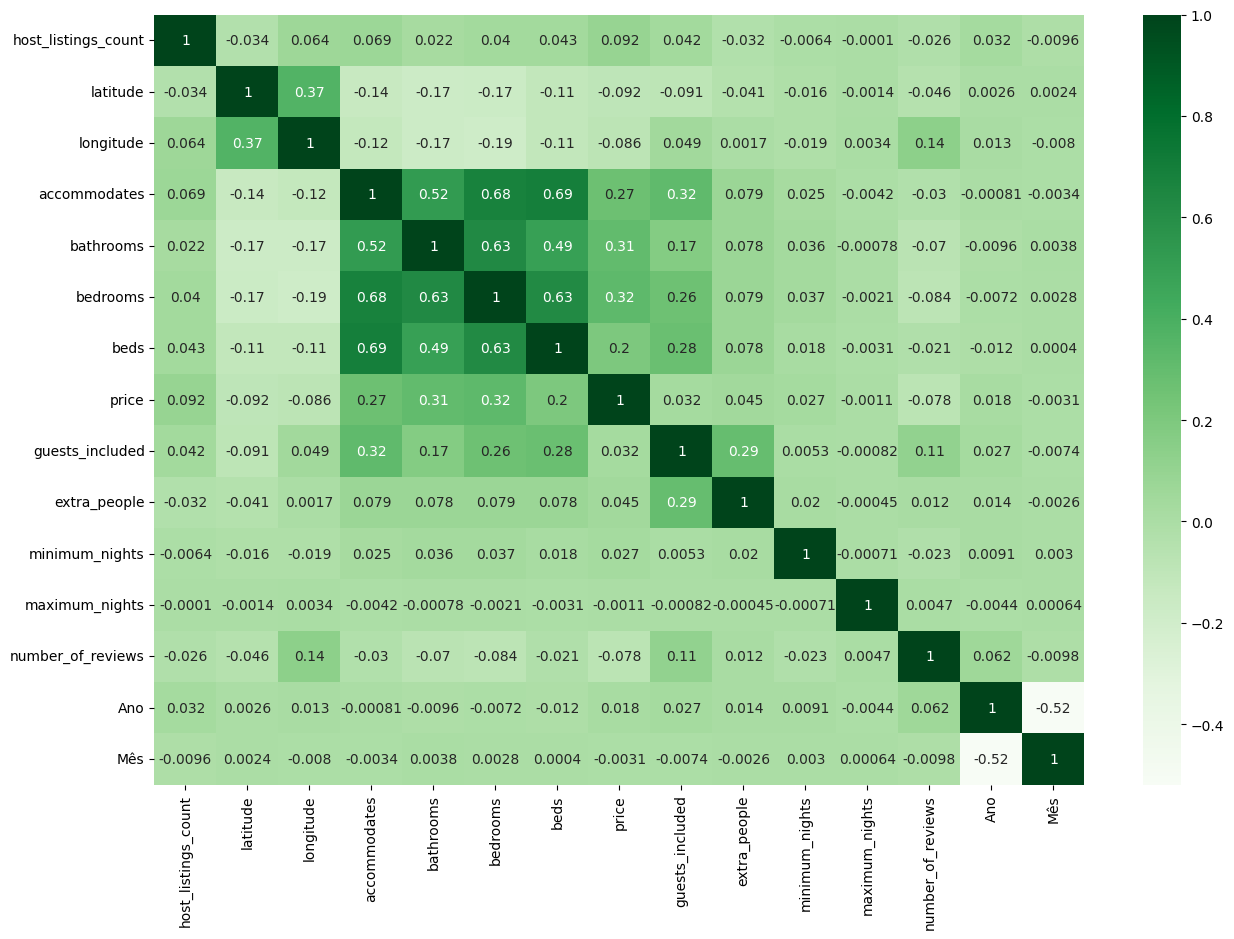

In [11]:
plt.figure(figsize=(15, 10))

sns.heatmap(base_airbnb.corr(numeric_only=True), annot=True, cmap='Greens')

plt.show()

Definições de funçoes para análise de outliers

- Vamos definir algumas funções para ajudar na análise de outliers da coluna

In [12]:
#criando função para definir limite de outliers
def limites(coluna):
      q1 = coluna.quantile(0.25)
      q3 = coluna.quantile(0.75)
      amplitude = q3 - q1
      limite_inferior = q1 - 1.5 * amplitude
      limite_superior = q3 + 1.5 * amplitude
      return limite_inferior, limite_superior

def excluir_outliers(df, nome_coluna):
      qtd_linhas = df.shape[0]
      lim_inferior, lim_superior = limites(df[nome_coluna])
      df = df.loc[(df[nome_coluna] >= lim_inferior) & (df[nome_coluna] <= lim_superior), :]
      linhas_removidas = df.shape[0] - qtd_linhas
      return df, linhas_removidas

In [13]:
#criando funçao para plotar graficos
def diagrama_caixa(coluna):
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.set_size_inches(15, 5)
      sns.boxplot(x=coluna, ax=ax1)
      ax2.set_xlim(limites(coluna))
      sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
     plt.figure(figsize=(18, 10))
     sns.displot(coluna, kde=True)

def grafico_barra(coluna):
      plt.figure(figsize=(18, 6))
      ax = sns.barplot(x=coluna.value_counts().index , y=coluna.value_counts())
      ax.set_xlim(limites(coluna))

Price

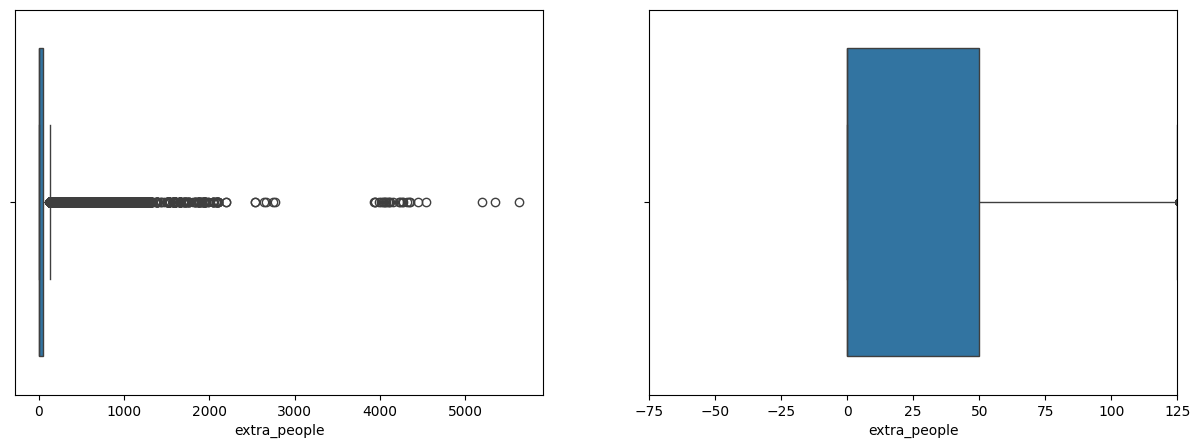

<Figure size 1800x1000 with 0 Axes>

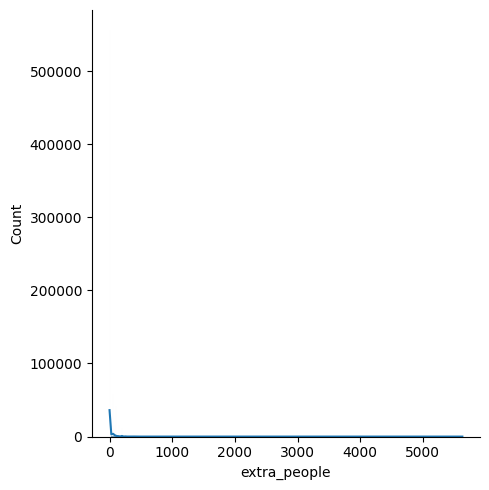

In [14]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

Coluna Price

Como estamos construindo um modelo para imoveis comuns, acredito que os valores acima do limite superior acredito que serao apenas de apartamentos de altissimo luxo, que nao e o nosso objetivo principal, por isso podemos excluir esses outliers

In [15]:
#excluindo outliers da coluna de price
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print(f'Linhas removidas {linhas_removidas}')

Linhas removidas -87282


Coluna Extra_People

In [16]:
#excluindo outliers extra_people
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print(f'Linhas removidas {linhas_removidas}')

Linhas removidas -59194


Coluna Accommodates

In [17]:
#excluindo outliers extra_people
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print(f'Linhas removidas {linhas_removidas}')

Linhas removidas -18552


Coluna Bathrooms

In [18]:
#excluindo outliers extra_people
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print(f'Linhas removidas {linhas_removidas}')

Linhas removidas -8339


Colunas Beds e Bedrooms

In [19]:
#Beds
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print(f'Linhas removidas {linhas_removidas}')


#Bedrons
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print(f'Linhas removidas {linhas_removidas}')

Linhas removidas -7995
Linhas removidas -5664


Coluna Guest_included

In [20]:
#Excluindo guest_included porque aparentemente os usuarios usam o padrao para preenchimento, isso pode considerar uma feature que nao e essencial
base_airbnb = base_airbnb.drop('guests_included', axis=1)

In [21]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print(f'Linhas removidas {linhas_removidas}')

base_airbnb = base_airbnb.drop('maximum_nights', axis=1)

base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)

Linhas removidas -42672


Tratamento de colunas com valores de texto

- property_type

property_type
Apartment                 524093
House                      57211
Condominium                30636
Serviced apartment         17243
Loft                       13357
Bed and breakfast           4286
Guest suite                 4146
Hostel                      3322
Other                       2495
Guesthouse                  2460
Villa                       1392
Aparthotel                  1226
Hotel                       1139
Townhouse                   1116
Boutique hotel               531
Chalet                       517
Tiny house                   495
Earth house                  479
Casa particular (Cuba)       303
Cottage                      263
Bungalow                     227
Dorm                         195
Cabin                        141
Castle                       140
Nature lodge                 131
Treehouse                     76
Boat                          56
Island                        54
Hut                           40
Campsite                     

<Axes: xlabel='count', ylabel='property_type'>

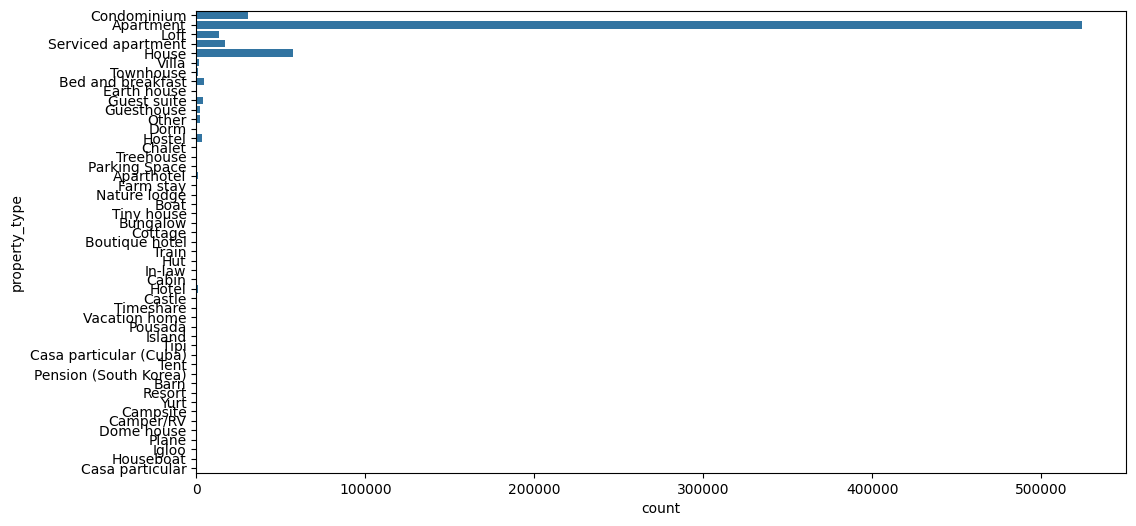

In [22]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(12, 6))
sns.countplot(base_airbnb['property_type'])

In [23]:
tabelas_tipo_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabelas_tipo_casa.index:
      if tabelas_tipo_casa[tipo] < 2_000:
            colunas_agrupar.append(tipo)

for tipo in colunas_agrupar:
      base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Other'

print(base_airbnb['property_type'].value_counts())

property_type
Apartment             524093
House                  57211
Condominium            30636
Serviced apartment     17243
Loft                   13357
Other                  11257
Bed and breakfast       4286
Guest suite             4146
Hostel                  3322
Guesthouse              2460
Name: count, dtype: int64


room_type
Entire home/apt    442885
Private room       209394
Shared room         13916
Hotel room           1816
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='room_type'>

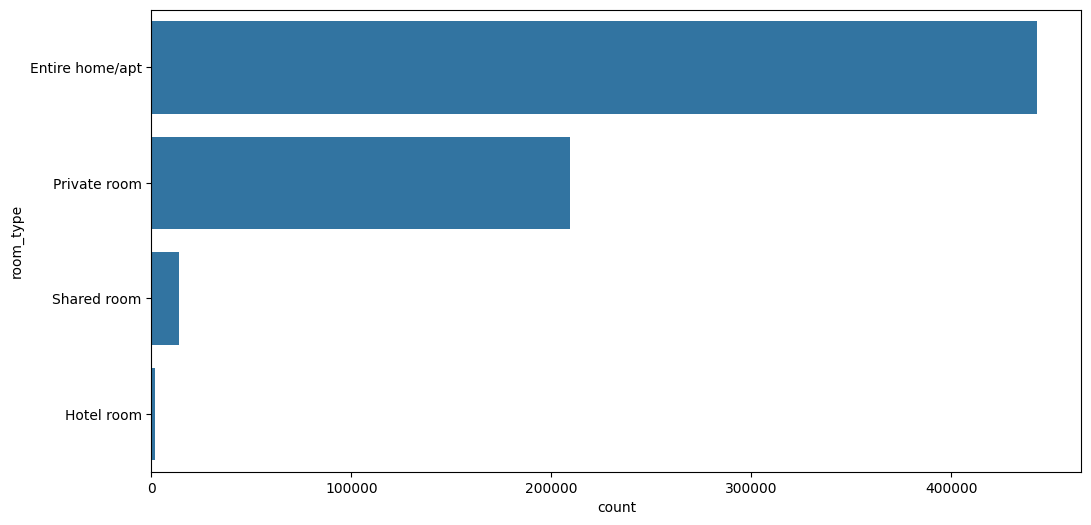

In [24]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(12, 6))
sns.countplot(base_airbnb['room_type'])

bed_type
Real Bed         656242
Pull-out Sofa      8263
Futon              1770
Airbed             1189
Couch               547
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='bed_type'>

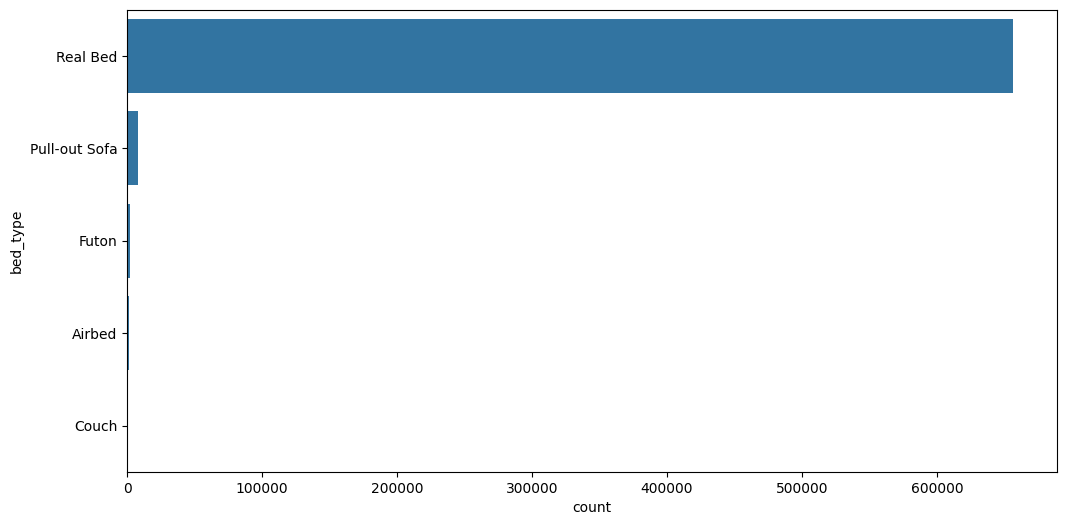

In [25]:
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(12, 6))
sns.countplot(base_airbnb['bed_type'])

In [26]:
tabelas_tipo_cama = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabelas_tipo_cama.index:
      if tabelas_tipo_cama[tipo] < 600_000:
            colunas_agrupar.append(tipo)

for tipo in colunas_agrupar:
      base_airbnb.loc[base_airbnb['bed_type'] == tipo, 'bed_type'] = 'Other'

print(base_airbnb['bed_type'].value_counts())

bed_type
Real Bed    656242
Other        11769
Name: count, dtype: int64


cancellation_policy
flexible                       278727
strict_14_with_grace_period    247303
moderate                       121410
strict                          12135
super_strict_60                  6020
super_strict_30                  2416
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='cancellation_policy'>

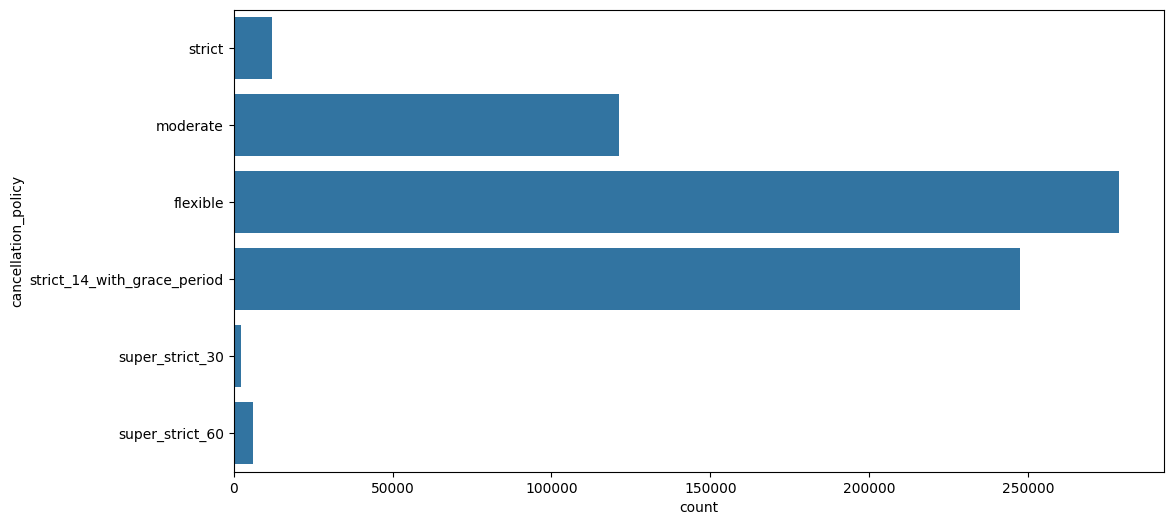

In [27]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(12, 6))
sns.countplot(base_airbnb['cancellation_policy'])

In [28]:
qtd_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in qtd_cancellation.index:
      if qtd_cancellation[tipo] < 10_000:
            colunas_agrupar.append(tipo)

for tipo in colunas_agrupar:
      base_airbnb.loc[base_airbnb['cancellation_policy'] == tipo, 'cancellation_policy'] = 'strict'

print(base_airbnb['cancellation_policy'].value_counts())

cancellation_policy
flexible                       278727
strict_14_with_grace_period    247303
moderate                       121410
strict                          20571
Name: count, dtype: int64


In [29]:
# avaliando a quantidade de amenities
base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

base_airbnb = base_airbnb.drop('amenities', axis=1)

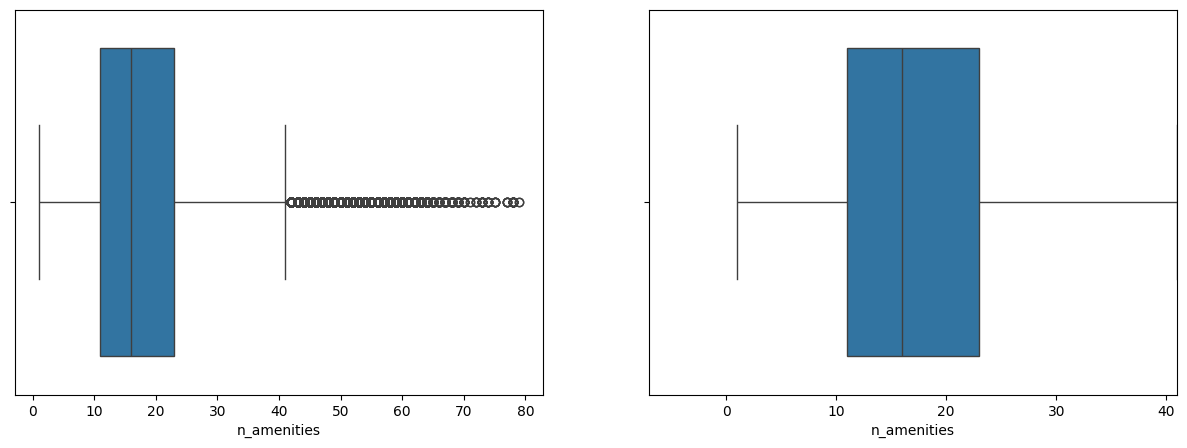

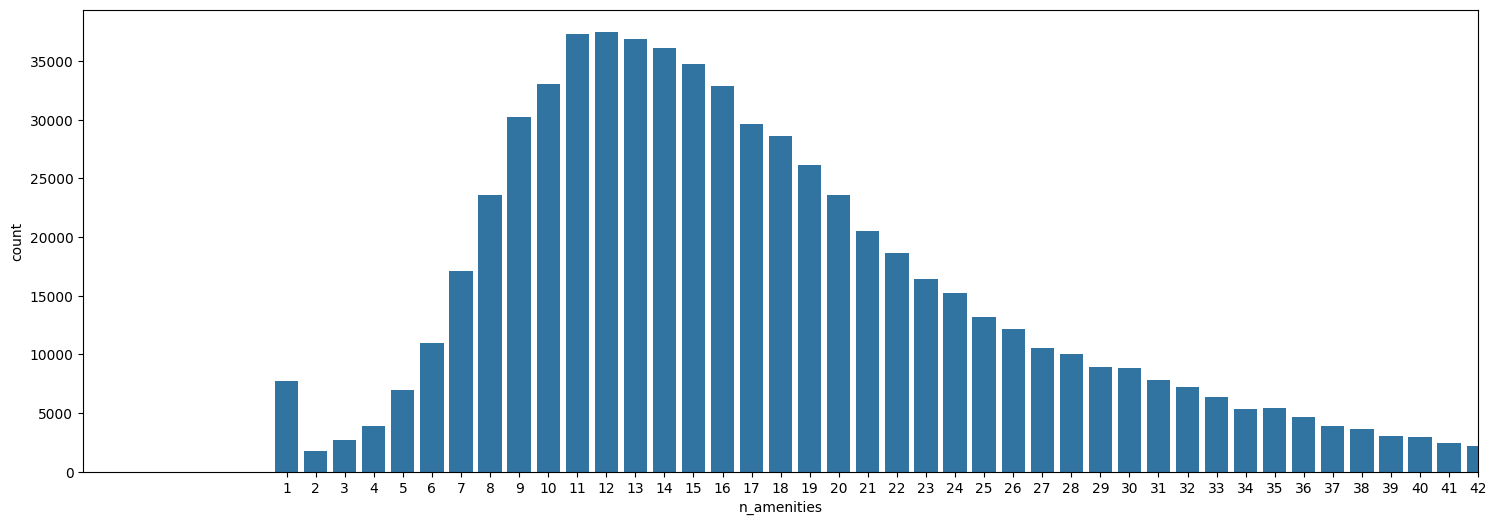

In [30]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [31]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print(f'{linhas_removidas} linhas removidas')

-19317 linhas removidas


In [32]:
amostra = base_airbnb.sample(n=50_000)
centro_mapa = {'lat': amostra.latitude.mean(), 'lon': amostra.longitude.mean()}

fig = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius=2.5, center=centro_mapa, zoom=10, mapbox_style='stamen-terrain')

fig.show()

### Encoding

Precisamos ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)

- Features de valor true ou false, vamos substituir por 1 e 0 respectivamente
- Features de categoria (features em que os valores da colunas são textos) vamos utilizar o método de encoding de variáveis dummies

In [33]:
# tratamento das colunas que são true ou false
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()

for coluna in colunas_tf:
      base_airbnb_cod.loc[base_airbnb_cod[coluna] == 't', coluna] = 1
      base_airbnb_cod.loc[base_airbnb_cod[coluna] == 'f', coluna] = 0

In [34]:

# tratamento das colunas que são categorias
colunas_cat = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_cat, dtype=int)
display(base_airbnb_cod.head(5))

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Other,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
1,1,2.0,-22.965919,-43.178962,5,1.0,2.0,2.0,270.0,51.0,...,1,0,0,0,0,1,0,0,1,0
3,0,3.0,-22.977117,-43.190454,3,1.0,1.0,2.0,161.0,45.0,...,1,0,0,0,0,1,0,0,1,0
4,1,1.0,-22.983024,-43.214270,3,1.0,1.0,2.0,222.0,68.0,...,1,0,0,0,0,1,0,0,1,0
5,1,1.0,-22.988165,-43.193588,3,1.5,1.0,2.0,308.0,86.0,...,1,0,0,0,0,1,0,0,1,0
6,1,1.0,-22.981269,-43.190457,2,1.0,1.0,2.0,219.0,80.0,...,1,0,0,0,0,1,0,0,1,0


### Modelo de Previsão

In [35]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
      r2 = r2_score(y_teste, previsao)
      RSME = np.sqrt(mean_squared_error(y_teste, previsao))
      return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f} '

#### Escolha dos modelos a serem testados:
      - Random Forest
      - Linear Regression
      - Extra Tree

In [36]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
           'LinearRegression': modelo_lr,
           'ExtraTrees': modelo_et
           }

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

Separar os dados do modelo em treino e teste + treino do modelo

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

for nome_modelo, modelo in modelos.items():
      #treinar
      modelo.fit(X_train, y_train)
      #testar
      previsao = modelo.predict(X_test)
      print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:96.93%
RSME:45.64 
Modelo LinearRegression:
R²:32.50%
RSME:213.89 
Modelo ExtraTrees:
R²:97.13%
RSME:44.08 


### Análise do Melhor Modelo

In [38]:
for nome_modelo, modelo in modelos.items():
      #testar
      previsao = modelo.predict(X_test)
      print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:96.93%
RSME:45.64 
Modelo LinearRegression:
R²:32.50%
RSME:213.89 
Modelo ExtraTrees:
R²:97.13%
RSME:44.08 


Modelo escolhido como melhor modelo: ExtraTreesRegressor
- Modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como nao tivemos uma grande diferenca de velocidade de treino e de previsao desse modelo com o RandomForest (que teve resultado proximos de R² e RSME), vamos escolher o modelo ExtraTrees. O modelo de regressao linear nao obteve um resultado satisfatorio, com valor de R² baixo e RSME alto em comparacao aos outros 2 mmodelos.

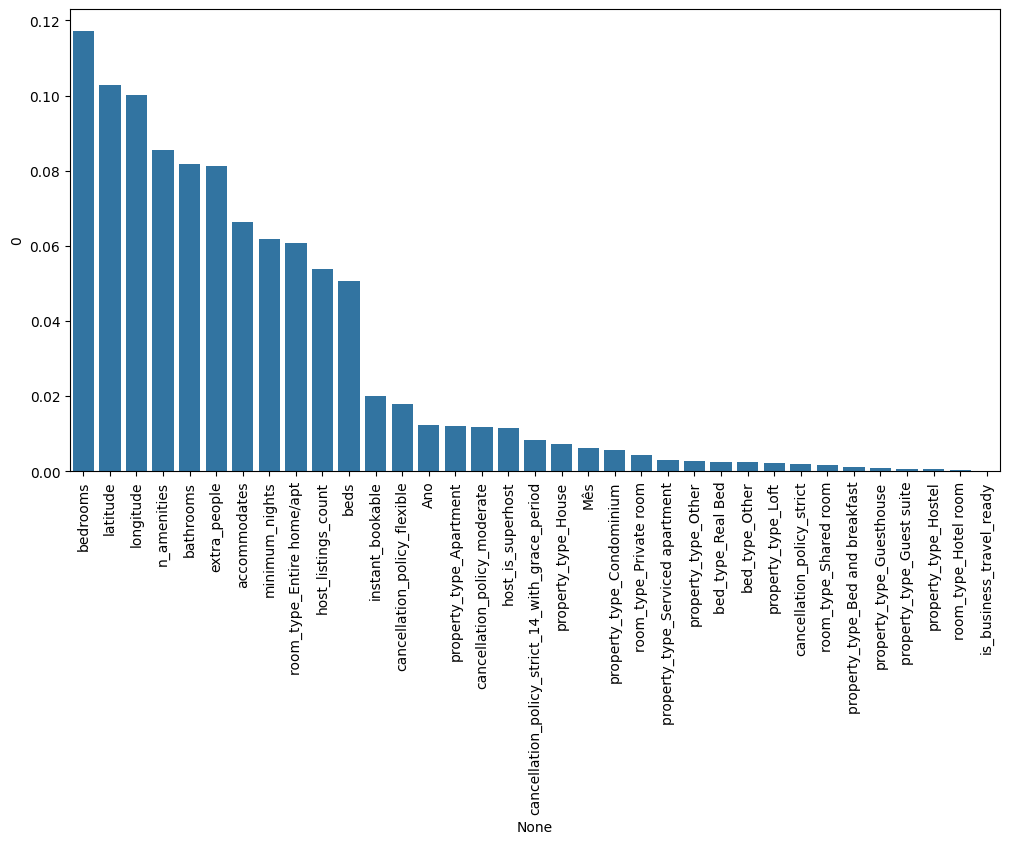

In [39]:
importancia_features = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

### Ajustes e Melhorias no Melhor Modelo

### Ajustes finais no modelo

- is_business_travel_ready nao parece ter muito impacto no nosso modelo, por isso para ser mais simples vamos excluir essa feature do nosso modelo

In [40]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees:
R²:97.15%
RSME:43.99 


In [41]:
base_teste = base_airbnb_cod.copy()

for coluna in base_teste:
      if 'bed_type' in coluna:
            base_teste = base_teste.drop(coluna, axis=1)
print(base_teste.columns)
y = base_teste['price']
X = base_teste.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'Ano', 'Mês',
       'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Other', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')
Modelo ExtraTrees:
R²:97.13%
RSME:44.12 


### Deploy do Projeto

- Passo 1 -> Criar arquivo do modelo(joblib)
- Passo 2 -> Escolher a forma de deploy:
      - Arquivo executável + Tkinter
      - Deploy em um microsite (flask)
      - Deploy apenas para uso direto (Streamlit)
- Passo 3 -> Outro arquivo Python (Pode ser Jupyter ou Pycharm)
- Passo 4 -> Importar streamlit e criar código
- Passo 5 -> Atribuir ao botão o carregamento do modelo
- Passo 6 -> Deploy feito 

In [42]:
X['price'] = y

X.to_csv(r'Dados\modelo_previsao.csv', index=False)

In [43]:
import joblib
joblib.dump(modelo_et, 'modelo.joblib')

['modelo.joblib']